In [64]:
import json
import os
from os.path import basename, exists
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
from matplotlib.colors import ListedColormap
from queue import PriorityQueue


In [65]:
# Load the data from MITRE ATT&CK softwares (https://attack.mitre.org/software/)
with open('../software_techniques.json') as f:
    software_techniques = json.load(f)

In [66]:

# Load the data from the tactics json file
with open('../tactics_techniques.json') as f:
    tactics_data = json.load(f)

# Convert tactics data to a dictionary
tactics_dict = {}
step = 0 # The step of the tactic. Used to sort techniques later.
for item in tactics_data:
    visited = False
    for technique in item["techniques"]:
        visited = True
        tactics_dict[technique["id"]] = (step, item["tactic"])
    if visited:
        step += 1
max_step = step-1

In [67]:
# Maps to store nodes of each tactic
tactics = {
    'Start': set(),
    'Initial Access': set(),
    'Execution': set(),
    'Persistence': set(),
    'Privilege Escalation': set(),
    'Defense Evasion': set(),
    'Credential Access': set(),
    'Discovery': set(),
    'Lateral Movement': set(),
    'Collection': set(),
    'Command and Control': set(),
    'Exfiltration': set(),
    'Impact': set(),
    'End': set(),
}

colors = ['gold', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'purple', 'violet', 'deeppink', 'brown', 'pink', 'grey']

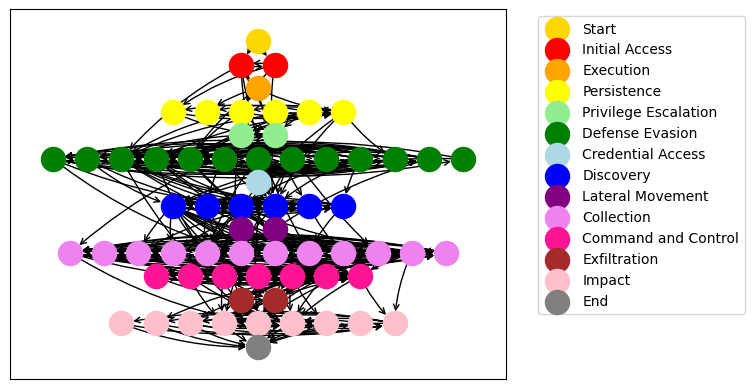

In [68]:
G = nx.DiGraph()
G.add_node('Start', tactic='Start', step=0)
tactics['Start'].add('Start')

G.add_node('End', tactic='End', step=max_step+1)
tactics['End'].add('End')

pos = {}

for software in software_techniques:
    software_techniques_pq = PriorityQueue()
    for technique in software['techniques']:
        technique_id = technique['technique_id']
        step = tactics_dict.get(technique_id)[0]
        software_techniques_pq.put((step, technique_id))

    prev_technique_id = None
    prev_step = None
    
    while not software_techniques_pq.empty():
        technique = software_techniques_pq.get()
        step = technique[0]
        technique_id = technique[1]
        tactic = tactics_dict.get(technique_id)[1]
        if tactic:
            G.add_node(technique_id, tactic=tactic, step=step)
            tactics[tactic].add(technique_id)
        if prev_technique_id is not None and technique_id != prev_technique_id:
            G.add_edge(prev_technique_id, technique_id)
            if prev_step is not None and prev_step == step:
                G.add_edge(technique_id, prev_technique_id)
        
        if step == 0:
            G.add_edge('Start', technique_id)
        if step == max_step:
            G.add_edge(technique_id, 'End')
        prev_step = step
        prev_technique_id = technique_id

# Calculate the number of techniques in each tactic
tactic_counts = {tactic: len(nodes) for tactic, nodes in tactics.items()}

# Calculate the spacing between nodes within each tactic
spacing = 1 / max(tactic_counts.values())

# Set the initial y-position for each tactic
y_positions = {tactic: -i for i, tactic in enumerate(tactics.keys())}

# used for centering
max_count = max(tactic_counts.values())

# Set the positions for the nodes within each tactic
for tactic, nodes in tactics.items():
    y = y_positions[tactic]
    for i, node in enumerate(nodes):
        # center graph
        x = i * spacing + max_count - tactic_counts[tactic] * spacing / 2
        pos[node] = (x, y)

# Draw the nodes and edges
for tactic, color in zip(tactics.keys(), colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'

# Add labels for the nodes
# labels = {node: node for node in G.nodes()}
# nx.draw_networkx_labels(G, pos=pos, labels=labels)

# Adjust the position of the legend
plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('attack_paths_network_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [142]:
virustotal_folder = "./virustotal"

apks = {}
for f in os.listdir(virustotal_folder):
    with open(f"{virustotal_folder}/{f}", "r") as f:
        mitigation_json = json.load(f)
        data = mitigation_json .get("data")
        hash = mitigation_json.get("md5")

        if not data:
            continue

        # try to get sandbox results
        sandbox = data.get("Zenbox android")
        if sandbox is None:
            sandbox = data.get("Zenbox Linux")
        if sandbox is None:
            continue

        sandbox_tactics = sandbox.get("tactics")

        techniques = []
        for tactic in sandbox_tactics:
            techniques += tactic.get("techniques")
        technique_ids = [t.get("id") for t in techniques]
        
        if len(technique_ids) > 0:
            apks[hash] = technique_ids

In [132]:
import pandas as pd 

df = pd.DataFrame(columns=["apk_hash", "base", "global_centrality", "local_centrality", "data_driven", "random"])


In [151]:
global_centrality_rankings = [
    "System Partition Integrity",
    "Security Updates",
    "Lock Bootloader",
    "Interconnection Filtering",
    "Enterprise Policy",
    "Encrypt Network Traffic",
    "Deploy Compromised Device Detection Method",
    "Attestation",
    "Application Developer Guidance",
]

data_driven_rankings = [
    "Security Updates",
    "Attestation",
    "Deploy Compromised Device Detection Method",
    "Application Developer Guidance",
    "Enterprise Policy",
    "Encrypt Network Traffic",
    "Interconnection Filtering",
    "Lock Bootloader",
    "System Partition Integrity",
]

random_rankings = [
    "Application Developer Guidance",
    "Deploy Compromised Device Detection Method",
    "Attestation",
    "Interconnection Filtering",
    "Enterprise Policy",
    "Lock Bootloader",
    "Security Updates",
    "System Partition Integrity",
    "Encrypt Network Traffic",
]

with open("mitigation_technique_mappings.json", "r") as f:
    mitigation_technique_mappings = json.load(f)

In [154]:
from networkx import all_simple_paths

for hash, apk in apks.items():
    sub_graph = nx.subgraph_view(G, filter_node=lambda technique: technique in apk)
    unfrozen_sub_graph = nx.DiGraph(sub_graph)
    attrs = nx.get_node_attributes(sub_graph,'step')
    if len(attrs) == 0:
        continue
    min_step = min(attrs.values())
    max_step = max(attrs.values())

    unfrozen_sub_graph.add_node('Start', tactic='Start', step=min_step-1)
    unfrozen_sub_graph.add_node('End', tactic='End', step=max_step+1)

    for node in unfrozen_sub_graph.nodes().data(data=True):
        if node[1].get('step') == min_step:
            unfrozen_sub_graph.add_edge('Start', node[0])
        if node[1].get('step') == max_step:
            unfrozen_sub_graph.add_edge(node[0], 'End')


    # for tactic, color in zip(tactics.keys(), colors):
    #     nx.draw_networkx_nodes(unfrozen_sub_graph, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
    # nx.draw_networkx_edges(unfrozen_sub_graph, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'
    # plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.show()

    # base
    base_gen = all_simple_paths(unfrozen_sub_graph, 'Start', 'End')
    base = 0
    for i in base_gen:
        base+=1


    # global centrality
    for mitigation in global_centrality_rankings:
        global_centrality = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        global_centrality_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_global_centrality_graph = nx.DiGraph(global_centrality_graph)
        
        global_centrality_gen = all_simple_paths(unfrozen_global_centrality_graph, 'Start', 'End')
        for i in global_centrality_gen:
            global_centrality+=1
        
        # break out if some paths are reduced
        if global_centrality != base:
            break

    # data-driven centrality
    for mitigation in data_driven_rankings:
        data_driven = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        data_driven_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_data_driven_graph = nx.DiGraph(data_driven_graph)
        
        data_driven_gen = all_simple_paths(unfrozen_data_driven_graph, 'Start', 'End')
        for i in data_driven_gen:
            data_driven+=1
        
        # break out if some paths are reduced
        if data_driven != base:
            break

    # random centrality
    for mitigation in random_rankings:
        random = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        random_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_random_graph = nx.DiGraph(random_graph)
        
        random_gen = all_simple_paths(unfrozen_random_graph, 'Start', 'End')
        for i in random_gen:
            random+=1
        
        # break out if some paths are reduced
        if random != base:
            break
    l =  [hash, base, global_centrality, None, data_driven, random]
    df2 = pd.DataFrame( l,
               columns=["apk_hash", "base", "global_centrality", "local_centrality", "data_driven", "random"])


AttributeError: 'DataFrame' object has no attribute 'append'

In [149]:
print(df)

  apk_hash base global_centrality local_centrality data_driven random  \
0      NaN  NaN               NaN              NaN         NaN    NaN   
1      NaN  NaN               NaN              NaN         NaN    NaN   
2      NaN  NaN               NaN              NaN         NaN    NaN   
3      NaN  NaN               NaN              NaN         NaN    NaN   
4      NaN  NaN               NaN              NaN         NaN    NaN   
5      NaN  NaN               NaN              NaN         NaN    NaN   

   f4dfbe13348a777b7dfda173a1479fb3  d1dc38f340fd3beafb6ece9905f0f862  \
0  f4dfbe13348a777b7dfda173a1479fb3  d1dc38f340fd3beafb6ece9905f0f862   
1                                18                                 1   
2                                 6                                 0   
3                              None                              None   
4                                 8                                 0   
5                                 8               